<a href="https://colab.research.google.com/github/ximeeb/ebertz-gross-lopez-tp-lcs/blob/master/cnn_diabetic_retinopathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
!pip install pandas

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from pandas.io.formats.info import DataFrameTableBuilder
import opendatasets as od
import pandas
import cv2
import os
import matplotlib.pyplot as plt
import json
from PIL import Image

In [ ]:
od.download("https://www.kaggle.com/datasets/tanlikesmath/diabetic-retinopathy-resized", force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ximeeb
Your Kaggle Key: ··········


100%|██████████| 7.25G/7.25G [01:29<00:00, 87.4MB/s]


In [2]:
datos = pandas.read_csv('/content/diabetic-retinopathy-resized/trainLabels_cropped.csv')
ids = list(datos.columns.values)[0]

MAX_NIVEL_CERO = 4000
et_0 = datos[datos.level == 0][:MAX_NIVEL_CERO]

datos = datos.query("level >= 1 and level <=4 ")
datos = datos.merge(et_0, how = 'outer')
datos = datos.sort_values(by = ids, ascending = True)

datos = datos[["image", "level"]]

etiquetas = np.array(datos["level"])

[0 0 0 ... 1 1 1]


In [3]:
# porcentaje de información a usar para validación y test
valid_size = 0.15
test_size = 0.2

In [20]:
# cantidad de imágenes de entrenamiento y de imágenes de prueba
indices = list(range(len(datos)))

division_valid = int(np.floor(valid_size * len(datos)))
division_test = int(np.floor(test_size * len(datos))) + division_valid

13306
1995 4656


In [19]:
def cargar_imagenes(inicio, fin):
  imgs = []
  TAMANO_IMG = 50

  for i in range(inicio, fin):
    path = "/content/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/" + datos["image"][i] + ".jpeg"
    imagen = cv2.imread(path, cv2.COLOR_BGR2GRAY)

    imagen = np.array(cv2.resize(imagen, (TAMANO_IMG, TAMANO_IMG)))
    imagen = imagen / 255

    imgs.append(imagen)

  return imgs

In [21]:
# cargamos imagenes de entrenamiento y de prueba
imgs_entrenamiento = cargar_imagenes(division_test, len(datos))
imgs_prueba = cargar_imagenes(division_valid, division_test)
imgs_validacion = cargar_imagenes(0, division_valid)

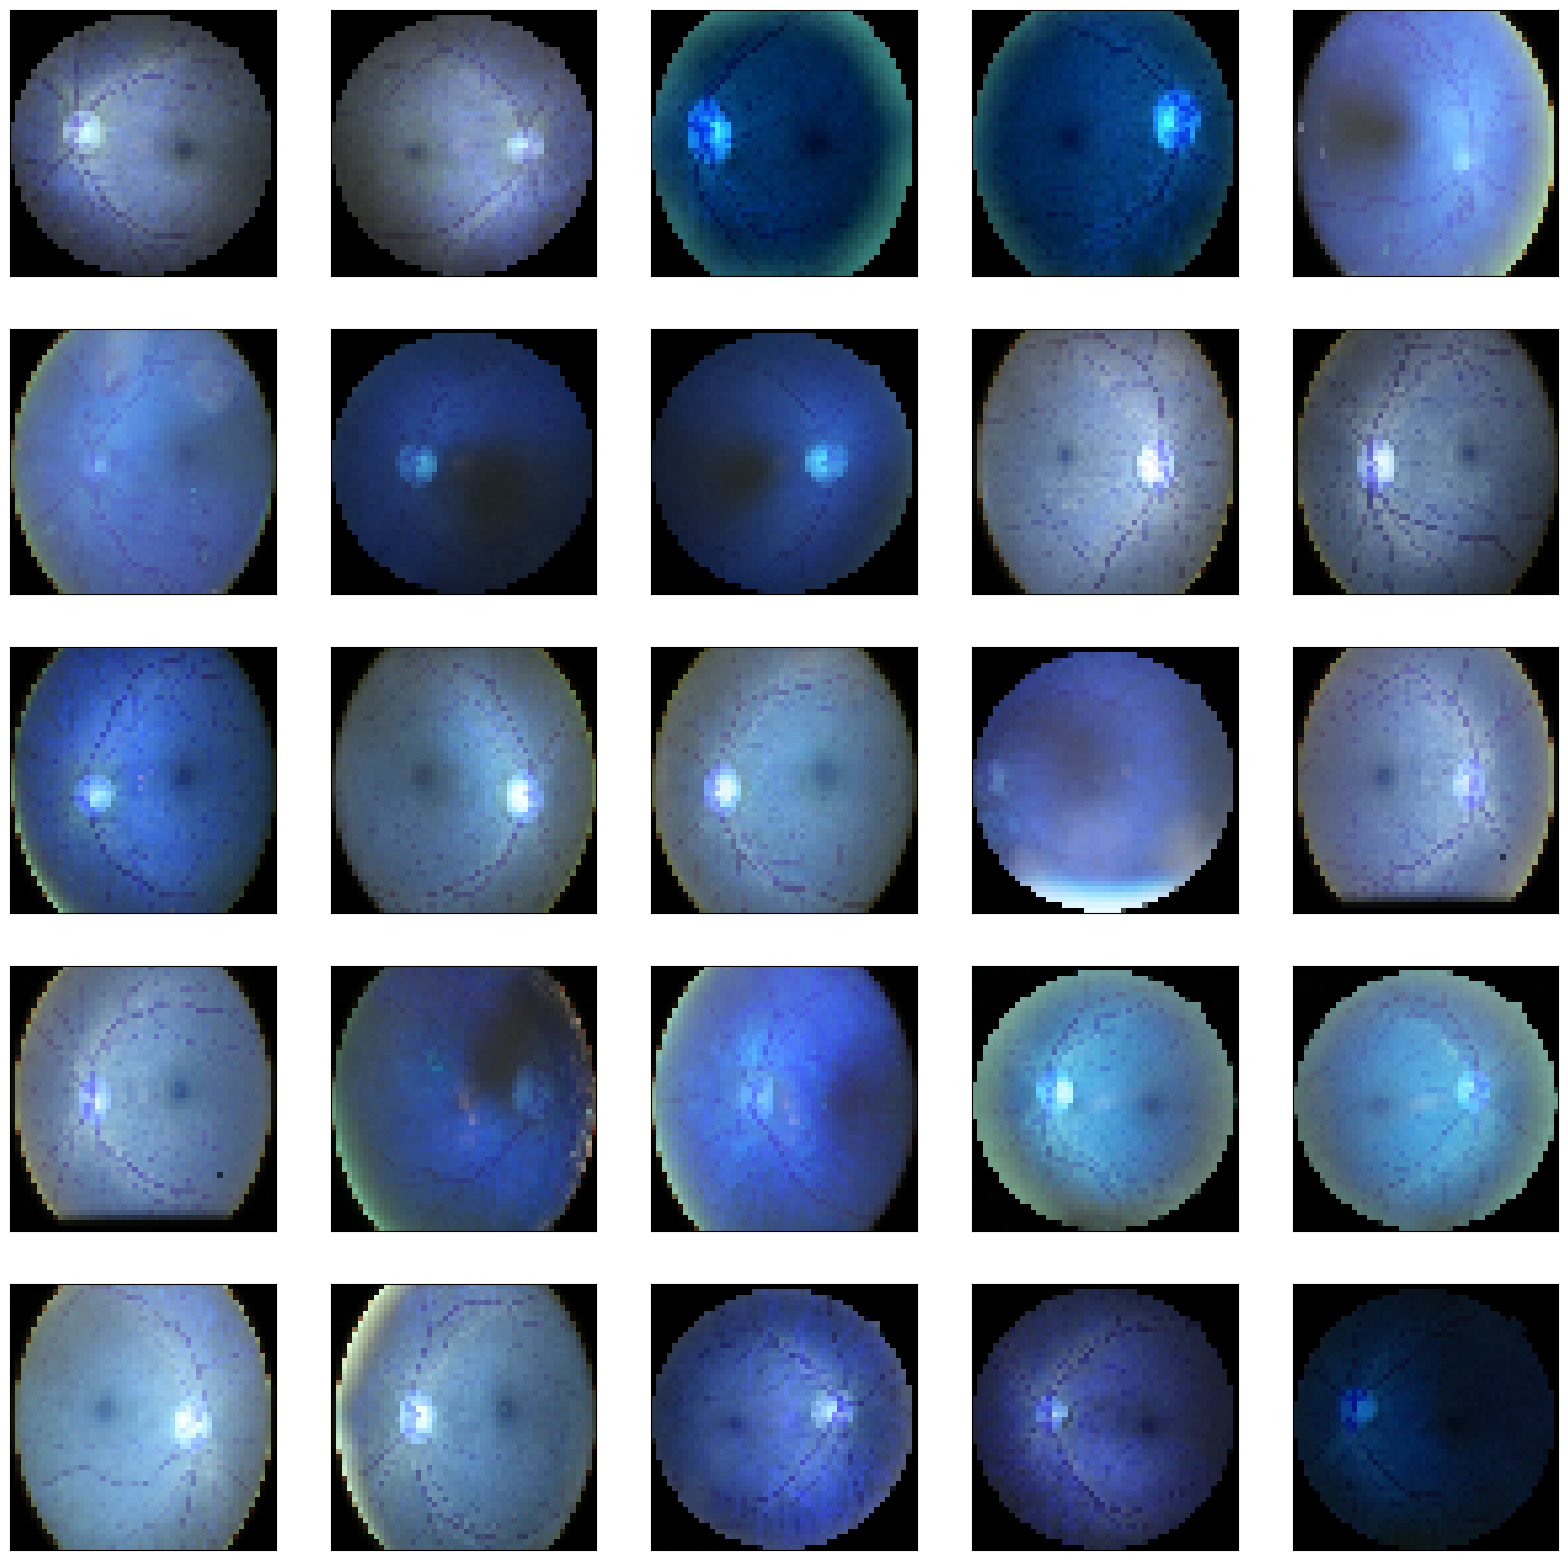

In [22]:
# mostramos algunas imágenes
plt.figure(figsize = (20, 20))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imgs_entrenamiento[i])

plt.show()

In [8]:
# convertimos imágenes a tensores
imgs_entrenamiento = np.array(imgs_entrenamiento).astype(float)
imgs_prueba = np.array(imgs_prueba).astype(float)
imgs_validacion = np.array(imgs_validacion).astype(float)

In [25]:
# convertimos etiquetas a tensores
etiquetas_entrenamiento = to_categorical(etiquetas[division_test:], num_classes = 5)
etiquetas_prueba = to_categorical(etiquetas[division_valid:division_test], num_classes = 5)
etiquetas_validacion = to_categorical(etiquetas[:division_valid], num_classes = 5)

In [ ]:
# generamos transformaciones en las imágenes
data = ImageDataGenerator (
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 )

data.fit(imgs_entrenamiento)  # ajustamos el generador de datos en los datos de entrenamiento

imgs_con_etiquetas = data.flow(imgs_entrenamiento, etiquetas_entrenamiento, batch_size=32,
         subset='training')

In [11]:
# modelo denso
modelo_denso = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (100, 100, 3)),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(150, activation = 'relu'),
    tf.keras.layers.Dense(150, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(5, activation = 'softmax'),
])

#Compilación
modelo_denso.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [ ]:
modelo_denso.summary()

In [26]:
# modelo convolucional
modelo_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding = 'Same', activation = 'relu', input_shape = (100, 100, 3)),
    tf.keras.layers.Conv2D(32, (5, 5), padding = 'Same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(15, (3, 3), padding = 'Same', activation = 'relu'),
    tf.keras.layers.Conv2D(15, (3, 3), padding = 'Same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation = 'softmax')
])

#Compilación
Tamano_lote=32
modelo_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [ ]:
modelo_cnn.summary()

In [13]:
# parámetros de entrenamiento
epochs = 5
b_size = 100

In [ ]:
print("Entrenando modelo denso...")
historial_mdenso = modelo_denso.fit(imgs_entrenamiento, etiquetas_entrenamiento, epochs=epochs, batch_size=b_size, validation_data=(imgs_validacion, etiquetas_validacion), use_multiprocessing=True, shuffle=True)
print("Modelo entrenado.")

In [ ]:
print("Entrenando modelo convolucional...")
historial = modelo_cnn.fit(imgs_entrenamiento, etiquetas_entrenamiento, epochs=epochs, batch_size=b_size, validation_data=(imgs_validacion, etiquetas_validacion), use_multiprocessing=True, shuffle=True)
print("Modelo entrenado.")

In [ ]:
# gráficas de precisión
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(4)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot (rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot (rango_epocas, val_acc, label='Precisión Pruebas')
plt. legend (loc='lower right')
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot (rango_epocas, loss, label= 'Pérdida de entrenamiento')
plt.plot (rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [16]:
def prediccion_es_correcta(esperada, obtenida):
  index_correcto = list(esperada).index(1)
  max_obtenido = max(obtenida)
  index_maximo = list(obtenida).index(max_obtenido)

  return index_correcto == index_maximo

In [ ]:
# testing
imagenes = np.array(imgs_prueba)

predicciones_cnn = modelo_cnn.predict(imagenes)
correctas_cnn = 0

predicciones_denso = modelo_denso.predict(imagenes)
correctas_denso = 0

resultados_esperados = etiquetas_prueba

print("cantidad de predicciones", len(predicciones_cnn))

for i in range(len(imagenes)):
  if prediccion_es_correcta(resultados_esperados[i], predicciones_cnn[i]):
    correctas_cnn += 1
  if prediccion_es_correcta(resultados_esperados[i], predicciones_denso[i]):
    correctas_denso += 1

print("CNN - correctas:", correctas_cnn, "incorrectas:", len(imagenes) - correctas_cnn)
print("Denso - correctas:", correctas_denso, "incorrectas:", len(imagenes) - correctas_denso)